# COGS 108 - Final Project (change this to your project's title)

## Permissions

Place an `X` in the appropriate bracket below to specify if you would like your group's project to be made available to the public. (Note that student names will be included (but PIDs will be scraped from any groups who include their PIDs).

* [  ] YES - make available
* [X] NO - keep private

# Overview

*Fill in your overview here*

# Names

- Daniela Molina
- Gabriel Beal
- Marc Isaia
- Haoxuan Cui

<a id='research_question'></a>
# Research Question

There are currently a substantial amount of teenagers and young adults (ages 14-28) who use the top social media applications in the United States. Taking that into consideration, does extensive usage (2+ hours/day?) of the aforementioned applications by these users generate an onset of symptoms that correspond to the clinical criteria of an Anxiety Disorder and/or Depressive Disorder?

<a id='background'></a>

## Background & Prior Work

*Fill in your background and prior work here* 

References (include links):
- 1)
- 2)

# Hypothesis


*Fill in your hypotheses here*

# Dataset(s)

CSV from the Google Form Survey we conducted:
- Dataset Name: Social Media and Mental Health
- Link to the dataset: https://raw.githubusercontent.com/COGS108/group036_wi21/main/Social%20Media%20and%20Mental%20Health.csv?token=AJJHPBN3BQHNXLMZPWR5UZTAFWDK2
- Number of Observations: 182
This dataset is the CSV file created from the responses received on our survey which collected data on social media use and mental health. It contains information about the individual’s identity, their social media usage (average time spent, which apps they use, when they first started using them), and their current mental health as well as whether they feel that it can be attributed to social media.

# Setup

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Statmodels & patsy
import patsy
import statsmodels.api as sm
from scipy.stats import pearsonr, norm, ttest_ind

In [2]:
df = pd.read_csv("Social_Media_and_Mental_Health.csv")

# Data Cleaning

Describe your data cleaning steps here.

In [3]:
# Rename columns
df.columns = ['time', 'gender', 'age', 'use social media', 'hours per day', 'days per week', 'check morning', 'check night', 'app count', 'start using', 'impact', 'mental health issues', 'suicidal thoughts', 'SM contributed', 'feedback']
# Remove responses with age over 28
df = df[df['age'] <= 28]
# Change yes and no to true and false
df = df.replace({"Yes": True, "No": False})
# Drop time column - not relevant to the research
df.drop(columns=['time'], inplace = True)
df["hours per day"] = df["hours per day"].str.replace(" hours", "")
df = df.replace({"Once a week": "1", "2-3 times a week": "2-3", "3-5 times a week": "3-5", "I use it every day":"7"})
df = df.replace({"Non-Binary ": "Non-binary", "Female- heads up this is worded ambiguously and people may interpret it as what gender they're attracted to": "Female"})
df['age'] = pd.to_numeric(df['age'])
df['impact'] = pd.to_numeric(df['impact'])

In [4]:
df_feedback = df
df = df.drop(columns=['feedback'])

In [5]:
# Additional data cleaning
df = df.replace({"a few times but have never acted on it": True, "Maybe ": "Prefer not to say", "Thought about it but can’t do it": True, "Passive suicidal thoughts. This means I do not really plan to ever commite sucide but instead just think about it as a option. Then, I snapped out of it because my mood imrpoves.": True})
df['suicidal thoughts'].value_counts()

False                95
True                 72
Prefer not to say    11
Name: suicidal thoughts, dtype: int64

In [6]:
df = df.replace({'Non-binary ': 'Non-binary', "Don’t know yet": "Prefer not to say"})
df['gender'].value_counts()

Male                 97
Female               73
Non-binary            5
Prefer not to say     5
Name: gender, dtype: int64

In [7]:
def checkDepression(string):
    if 'Depression' in string:
        return True
    else:
        return False

In [8]:
def checkAnxiety(string):
    if 'Anxiety' in string:
        return True
    else:
        return False

In [9]:
df['Depression'] = df['mental health issues'].apply(checkDepression)
df['Anxiety'] = df['mental health issues'].apply(checkAnxiety)

In [10]:
# Removing mental health issues due to the reduced scope of the question
df = df.drop(columns=['mental health issues'])

In [11]:
# Count how many social media apps they use (out of the options we gave)
def appCount(string):
    if 'None of the above' in string:
        return 0
    semicolons = string.count(';')
    return semicolons + 1

In [12]:
df['app count'] = df['app count'].apply(appCount)

In [13]:
df

,gender,age,use social media,hours per day,days per week,check morning,check night,app count,start using,impact,suicidal thoughts,SM contributed,Depression,Anxiety
0,Female,22,True,2-3,3-5,True,False,2,Middle School,6,True,Maybe,True,True
1,Female,22,True,1-2,7,False,True,4,High School,7,False,Maybe,True,True
2,Female,21,True,4+,7,True,True,4,Elementary School,5,False,True,True,False
3,Female,19,True,4+,3-5,True,True,4,Elementary School,3,True,True,True,True
4,Female,21,True,2-3,7,True,True,2,High School,4,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
177,Male,24,True,3-4,7,True,True,1,Middle School,4,True,Maybe,True,True
178,Male,20,True,2-3,7,True,True,4,High School,5,False,False,False,False
179,Male,23,True,1-2,7,True,False,0,High School,3,False,True,False,False
180,Male,19,True,1-2,NaN,False,True,1,High School,5,True,False,False,False


In [14]:
# Change hours per day to quantitative variable by taking average of range
def hoursToInt(string):
    if string in "0-1":
        return 0.5
    elif string == "1-2":
        return 1.5
    elif string == "2-3":
        return 2.5
    elif string == "3-4":
        return 3.5
    else:
        return 4.5

In [15]:
df['average hours'] = df['hours per day'].apply(hoursToInt)

In [16]:
df

,gender,age,use social media,hours per day,days per week,check morning,check night,app count,start using,impact,suicidal thoughts,SM contributed,Depression,Anxiety,average hours
0,Female,22,True,2-3,3-5,True,False,2,Middle School,6,True,Maybe,True,True,2.5
1,Female,22,True,1-2,7,False,True,4,High School,7,False,Maybe,True,True,1.5
2,Female,21,True,4+,7,True,True,4,Elementary School,5,False,True,True,False,4.5
3,Female,19,True,4+,3-5,True,True,4,Elementary School,3,True,True,True,True,4.5
4,Female,21,True,2-3,7,True,True,2,High School,4,False,True,False,False,2.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
177,Male,24,True,3-4,7,True,True,1,Middle School,4,True,Maybe,True,True,3.5
178,Male,20,True,2-3,7,True,True,4,High School,5,False,False,False,False,2.5
179,Male,23,True,1-2,7,True,False,0,High School,3,False,True,False,False,1.5
180,Male,19,True,1-2,NaN,False,True,1,High School,5,True,False,False,False,1.5


# Data Analysis & Results

Include cells that describe the steps in your data analysis.

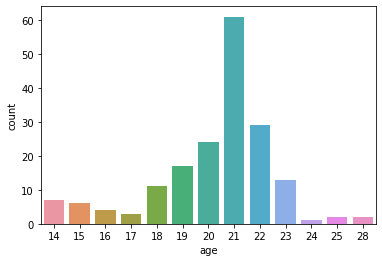

In [17]:
sns.countplot(x='age', data=df)

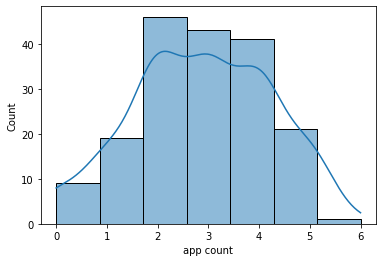

In [18]:
sns.histplot(df['app count'], bins=7, kde=True);

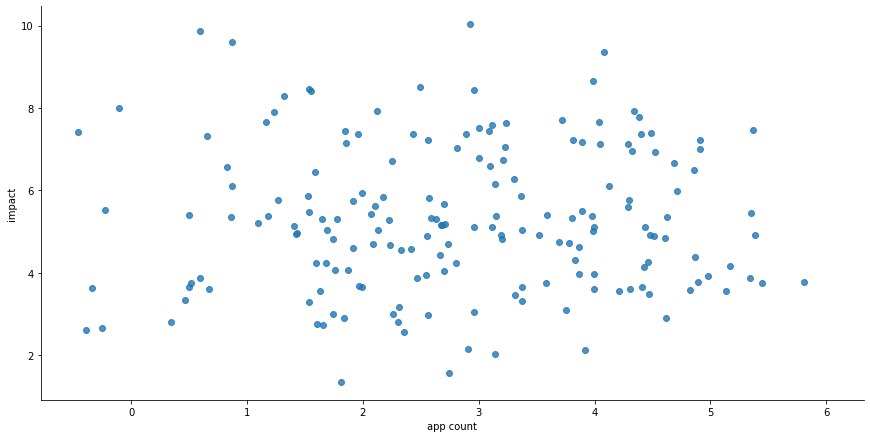

In [19]:
# jitter points to see relationship between quantitative variables
sns.lmplot(x='app count', y='impact', data=df, 
           fit_reg=False, height=6, aspect=2, 
           x_jitter=.5, y_jitter=.5);

In [20]:
x = df['app count']
y = df['impact']
np.corrcoef(x, y)

array([[ 1.        , -0.00387835],
       [-0.00387835,  1.        ]])

The pearson correlation of -0.0039 indicates that the amount of social media applications an individual uses has a miniscule negative correlation to the positive/negative impact of social media on their mental health. This is likely due to the amount of neutral (5) responses we received for impact.

In [21]:
outcome, predictors = patsy.dmatrices('y ~ x')
mod = sm.OLS(outcome, predictors)
res = mod.fit() 
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.006
Method:                 Least Squares   F-statistic:                  0.002677
Date:                Wed, 03 Mar 2021   Prob (F-statistic):              0.959
Time:                        14:09:04   Log-Likelihood:                -353.51
No. Observations:                 180   AIC:                             711.0
Df Residuals:                     178   BIC:                             717.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      5.3085      0.301     17.643      0.0

With a Beta 1 value of -.0049 this means that for every app count increase there is an expected -0.0049 increase in impact which means that for every app count increase (by 1 app) there is a very slight increase in the negative impact that it has on a users' mental health. The p' value of 0.959 means that we cannot reject the null hypothesis between app count and impact.

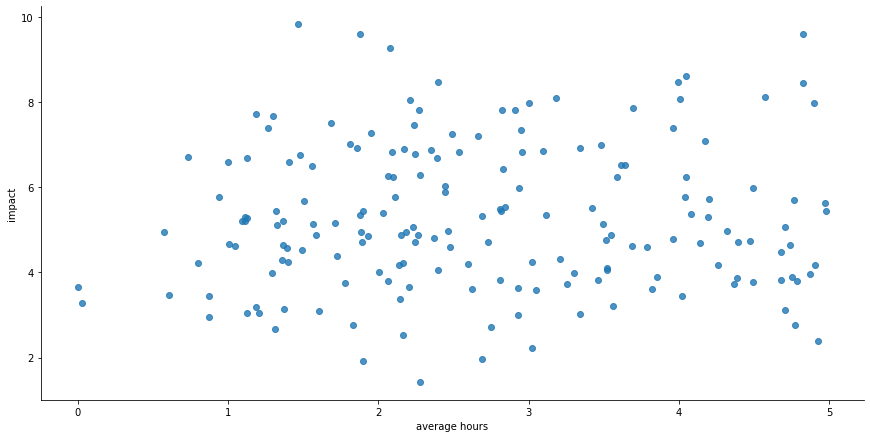

In [26]:
# jitter points to see relationship between quantitative variables
sns.lmplot(x='average hours', y='impact', data=df, 
           fit_reg=False, height=6, aspect=2, 
           x_jitter=.5, y_jitter=.5);

In [23]:
x = df['average hours']
y = df['impact']
np.corrcoef(x, y)

array([[1.        , 0.04304714],
       [0.04304714, 1.        ]])

In [24]:
outcome, predictors = patsy.dmatrices('y ~ x')
mod = sm.OLS(outcome, predictors)
res = mod.fit() 
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                 -0.004
Method:                 Least Squares   F-statistic:                    0.3305
Date:                Wed, 03 Mar 2021   Prob (F-statistic):              0.566
Time:                        14:22:15   Log-Likelihood:                -353.35
No. Observations:                 180   AIC:                             710.7
Df Residuals:                     178   BIC:                             717.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      5.1243      0.323     15.870      0.0

From the Beta 1 value we can see that a 1 unit increase in average hours leads to a .0627 unit increase in impact which means that in our data we gathered there is a small positive correlation between average hours spent on social media and a positive impact on mental health. However due to the high p-value of .566 there is not enough of a correlation to reject the null hypothesis once again. 

In [25]:
df.corr()

,age,use social media,app count,impact,Depression,Anxiety,average hours
age,1.000000,0.102915,0.181497,-0.159554,0.159373,0.017655,-0.076622
use social media,0.102915,1.000000,0.157101,-0.073916,0.060324,-0.086446,0.139682
app count,0.181497,0.157101,1.000000,-0.003878,0.199259,0.137714,0.214826
impact,-0.159554,-0.073916,-0.003878,1.000000,-0.078471,-0.115061,0.043047
Depression,0.159373,0.060324,0.199259,-0.078471,1.000000,0.427984,0.163435
Anxiety,0.017655,-0.086446,0.137714,-0.115061,0.427984,1.000000,0.206367
average hours,-0.076622,0.139682,0.214826,0.043047,0.163435,0.206367,1.000000


This table shows the Pearson corrleation values between each variable in our dataframe.

The r value of app count and Depression is 0.199259, which means that there is a slight positive correlation between these two. The higher the app count, the more likely an individual is to have Depression. Similarly, the r value for app count and Anxiety is 0.137714. Although this value is slightly lower, there is still a small positive correlation between these two. The highter the app count, the more likely an individual is to have Anxiety.

The r value of average hours and Depression is 0.163435, which again tells us that there is a positive correlation. Average hours and Anxiety follows the same correlation but is slightly higher at 0.206367. From these values, we can conclude that the more hours an individual uses social media on a daily basis, the more likely they are to have Depression and Anxiety.

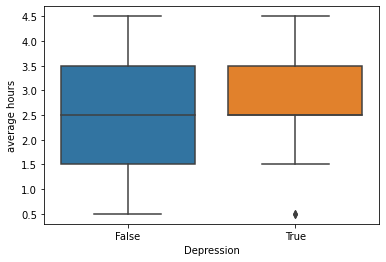

In [32]:
sns.boxplot(x='Depression', y='average hours', data=df)

In [50]:
df[df['Depression'] == True]['SM contributed'].value_counts()

Maybe    29
True     23
False    19
Name: SM contributed, dtype: int64

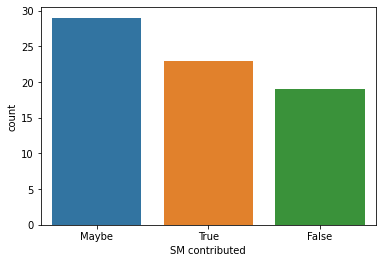

In [53]:
sns.countplot(x='SM contributed', data=df[df['Depression'] == True])

In [51]:
df[df['Anxiety'] == True]['SM contributed'].value_counts()

True     34
Maybe    27
False    16
Name: SM contributed, dtype: int64

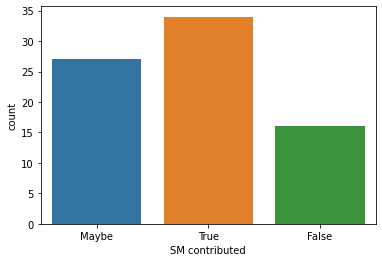

In [52]:
sns.countplot(x='SM contributed', data=df[df['Anxiety'] == True])

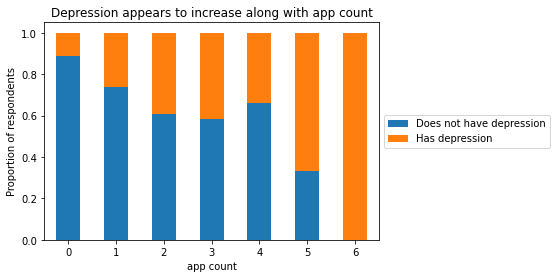

In [31]:
df2 = df.groupby([ 'Depression','app count'])['Depression'].count().unstack('app count').fillna(0)
sub_df2 = np.transpose(df2.div(df2.sum()))

# generate plot
ax = sub_df2.plot(kind='bar', stacked=True, rot=0,
                  title='Depression appears to increase along with app count')

# customize plot
ax.legend(('Does not have depression','Has depression'), loc='center left', bbox_to_anchor=(1.0, 0.5))
ax.set_ylabel("Proportion of respondents");

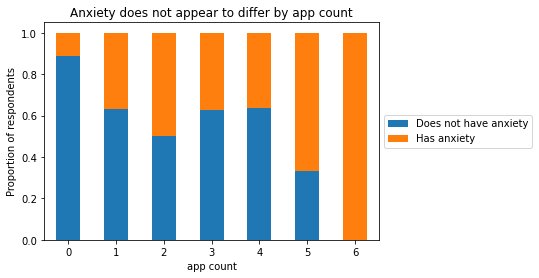

In [64]:
df2 = df.groupby([ 'Anxiety','app count'])['Anxiety'].count().unstack('app count').fillna(0)
sub_df2 = np.transpose(df2.div(df2.sum()))

# generate plot
ax = sub_df2.plot(kind='bar', stacked=True, rot=0,
                  title='Anxiety does not appear to differ by app count')

# customize plot
ax.legend(('Does not have anxiety','Has anxiety'), loc='center left', bbox_to_anchor=(1.0, 0.5))
ax.set_ylabel("Proportion of respondents");

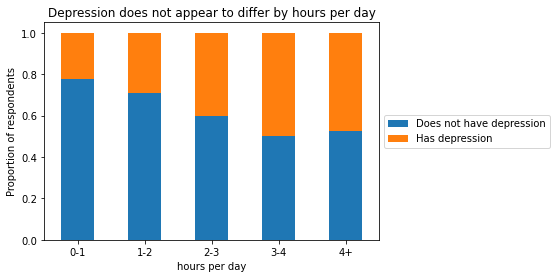

In [63]:
df2 = df.groupby([ 'Depression','hours per day'])['Depression'].count().unstack('hours per day').fillna(0)
sub_df2 = np.transpose(df2.div(df2.sum()))

# generate plot
ax = sub_df2.plot(kind='bar', stacked=True, rot=0,
                  title='Depression does not appear to differ by hours per day')

# customize plot
ax.legend(('Does not have depression','Has depression'), loc='center left', bbox_to_anchor=(1.0, 0.5))
ax.set_ylabel("Proportion of respondents");

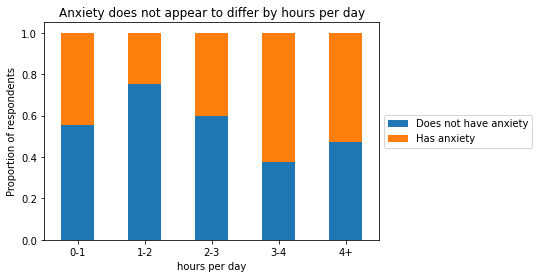

In [67]:
df2 = df.groupby([ 'Anxiety','hours per day'])['Anxiety'].count().unstack('hours per day').fillna(0)
sub_df2 = np.transpose(df2.div(df2.sum()))

# generate plot
ax = sub_df2.plot(kind='bar', stacked=True, rot=0,
                  title='Anxiety does not appear to differ by hours per day')

# customize plot
ax.legend(('Does not have anxiety','Has anxiety'), loc='center left', bbox_to_anchor=(1.0, 0.5))
ax.set_ylabel("Proportion of respondents");

# Ethics & Privacy

*Fill in your ethics & privacy discussion here*

# Conclusion & Discussion

*Fill in your discussion information here*

# Team Contributions

*Specify who in your group worked on which parts of the project.*